# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

Clustering resources
- https://github.com/jrkreiger/instacart-analysis/blob/master/instacart-analysis.ipynb
- https://medium.com/towards-data-science/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe


Other resources
- https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

# NOTAS para adicionar
- EXPERIMENTAR DBSCAN
- feature selection (use variance)
- Eugenia Heatmap
- adicionar rate de compra de departments

Links datasets user and sample
sample: https://drive.google.com/file/d/1yWG47xO_8CLTdYIjo3k3007WxUgFpZjl/view?usp=sharing
total: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link
normal zip: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link

# File and libraries

In [24]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [25]:
%run "scripts/dslabs_functions.py"

# data functions

In [68]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [27]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    # sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    # users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    # sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    # users_df=users_df.sample(frac=sample)






users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41242 entries, 0 to 41241
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        41242 non-null  int64  
 1   total_orders                   41242 non-null  int64  
 2   mean_products                  41242 non-null  float64
 3   max_products                   41242 non-null  int64  
 4   std_num_products               41242 non-null  float64
 5   mean_lag_between_orders        41242 non-null  float64
 6   std_lag_between_orders         41242 non-null  float64
 7   mean_reorder_rate              41242 non-null  float64
 8   mean_weekend_order_rate        41242 non-null  float64
 9   mean_order_dow                 41242 non-null  float64
 10  top_order_dow                  41242 non-null  int64  
 11  order_dow_variety              41242 non-null  int64  
 12  top_order_hour                 41242 non-null 

## variable type definition

In [28]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(users_df)
print(variable_types)


{'numeric': ['total_orders', 'mean_products', 'max_products', 'std_num_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order_rate', 'mean_order_dow', 'top_order_dow', 'order_dow_variety', 'top_order_hour', 'order_hour_variety', 'std_order_hour', 'mean_peak_time_of_day_rate', 'top_order_time_of_day_enc', 'order_time_of_day_enc_variety'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


# Cluster Data Prep

## drop nulls

- this will drop all first buying orders from the dataframe

In [29]:
# drop any null values
# data=data.dropna()

users_df=users_df.dropna()

## Drop outliers

In [30]:
numeric_vars = variable_types["numeric"]

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000
mean,15.643179,11.878678,17.711823,3.949834,15.415423,6.612661,0.431978,0.266318,2.746179,2.519228,4.686266,13.286456,7.207337,3.312760,0.730656,1.671613,2.840745
std,16.715787,6.654331,10.205300,2.527559,7.205835,3.261905,0.212488,0.217033,1.018355,2.148718,1.686777,3.988021,3.888638,1.484343,0.237743,1.743620,0.816556
min,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.570796,1.000000
25%,5.000000,7.074074,10.000000,2.110218,9.482759,4.225585,0.266667,0.097693,2.107143,1.000000,3.000000,10.000000,4.000000,2.299629,0.585073,1.570796,2.000000
50%,9.000000,10.826087,16.000000,3.476880,14.625000,7.034149,0.428571,0.238095,2.750000,2.000000,5.000000,13.000000,6.000000,3.178782,0.770200,1.570796,3.000000
75%,19.000000,15.494591,23.000000,5.232681,20.696234,9.024985,0.597403,0.388889,3.369565,5.000000,6.000000,16.000000,10.000000,4.162034,0.936842,3.141593,3.000000
max,99.000000,61.189459,109.000000,32.568721,30.000000,21.213203,0.989529,1.000000,6.000000,6.000000,7.000000,23.000000,24.000000,11.519394,1.000000,3.141593,4.000000


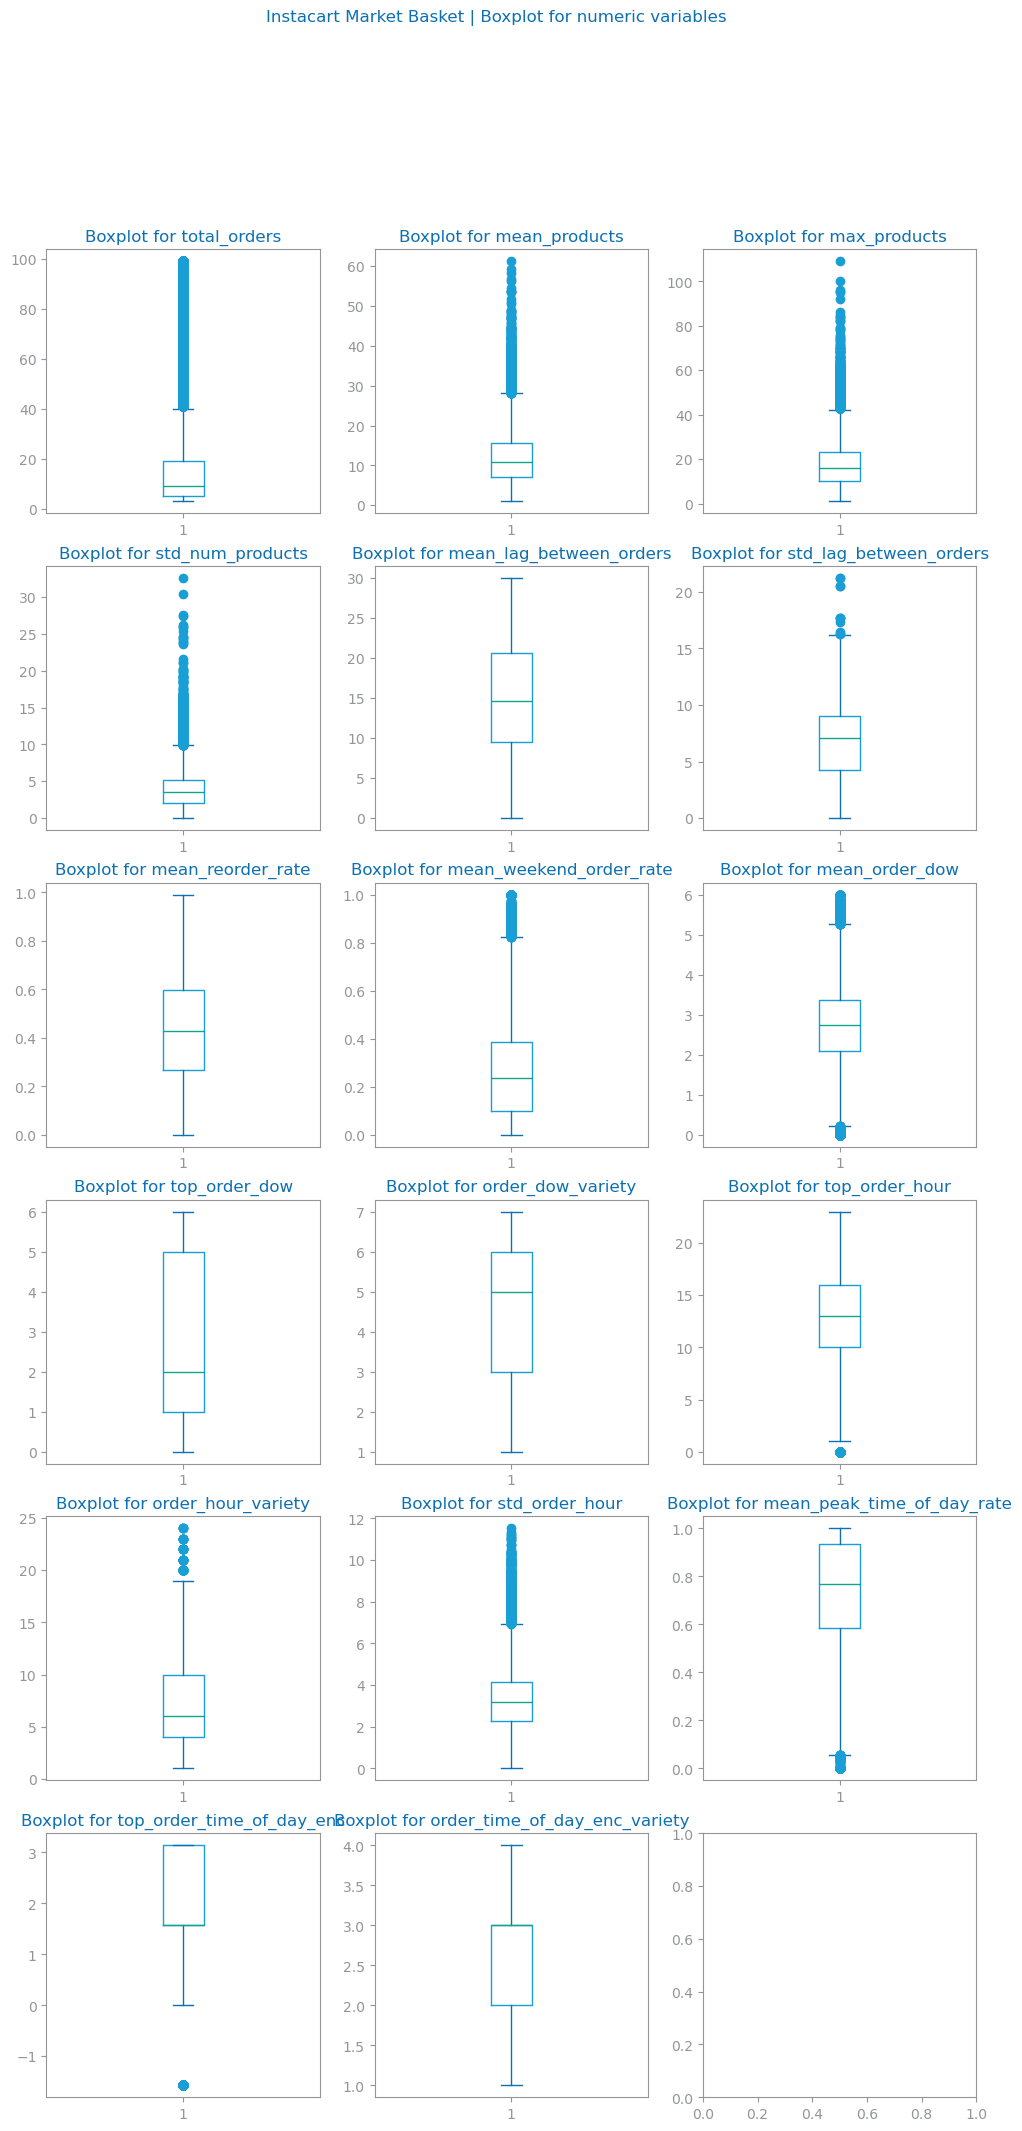

In [31]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [32]:



def truncate_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df[var] = np.where(df[var] < lower_bound, lower_bound, df[var])
			df[var] = np.where(df[var] > upper_bound, upper_bound, df[var])
	return df



def drop_numeric_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
	return df



users_df = truncate_outliers(users_df, summary5, numeric_vars)


# outlier_drop = ['total_orders', 'total_products']
users_df = drop_numeric_outliers(users_df, summary5, numeric_vars)


users_df=users_df[users_df['total_orders']<=40]
# users_df=users_df[users_df['total_products']<=1500]
# users_df=users_df[users_df['order_day_variety']<=4]


# users_df = drop_numeric_outliers(users_df, summary5, numeric_vars)

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000
mean,13.177966,11.351656,16.895744,3.713063,15.076223,6.738192,0.431119,0.249708,2.743966,2.382366,4.675880,13.223550,6.842394,3.241910,0.752413,1.950933,2.817608
std,9.973800,4.678174,7.225326,1.761320,5.454158,2.417466,0.160628,0.156479,0.710509,1.719800,1.337360,2.941761,2.899574,1.039400,0.176580,1.252780,0.618645
min,3.000000,5.224347,7.506523,1.422275,8.209588,3.350756,0.219491,0.049285,1.727824,0.370510,2.999489,9.298434,3.318699,1.828417,0.492914,-0.072006,2.024189
25%,5.000000,7.074074,10.000000,2.110218,9.482759,4.225585,0.266667,0.097693,2.107143,1.000000,3.000000,10.000000,4.000000,2.299629,0.585073,1.570796,2.024189
50%,9.000000,10.826087,16.000000,3.476880,14.625000,7.034149,0.428571,0.238095,2.750000,2.000000,5.000000,13.000000,6.000000,3.178782,0.770200,1.570796,3.000000
75%,19.000000,15.494591,23.000000,5.232681,20.696234,9.024985,0.597403,0.388889,3.369565,4.667946,6.000000,16.000000,10.000000,4.162034,0.936842,3.141593,3.000000
max,32.358967,18.533009,27.917123,6.477393,22.621259,9.874566,0.644466,0.483350,3.764534,4.667946,6.373044,17.274477,11.095975,4.797103,0.968399,3.141593,3.657301


### New Outlier visualization

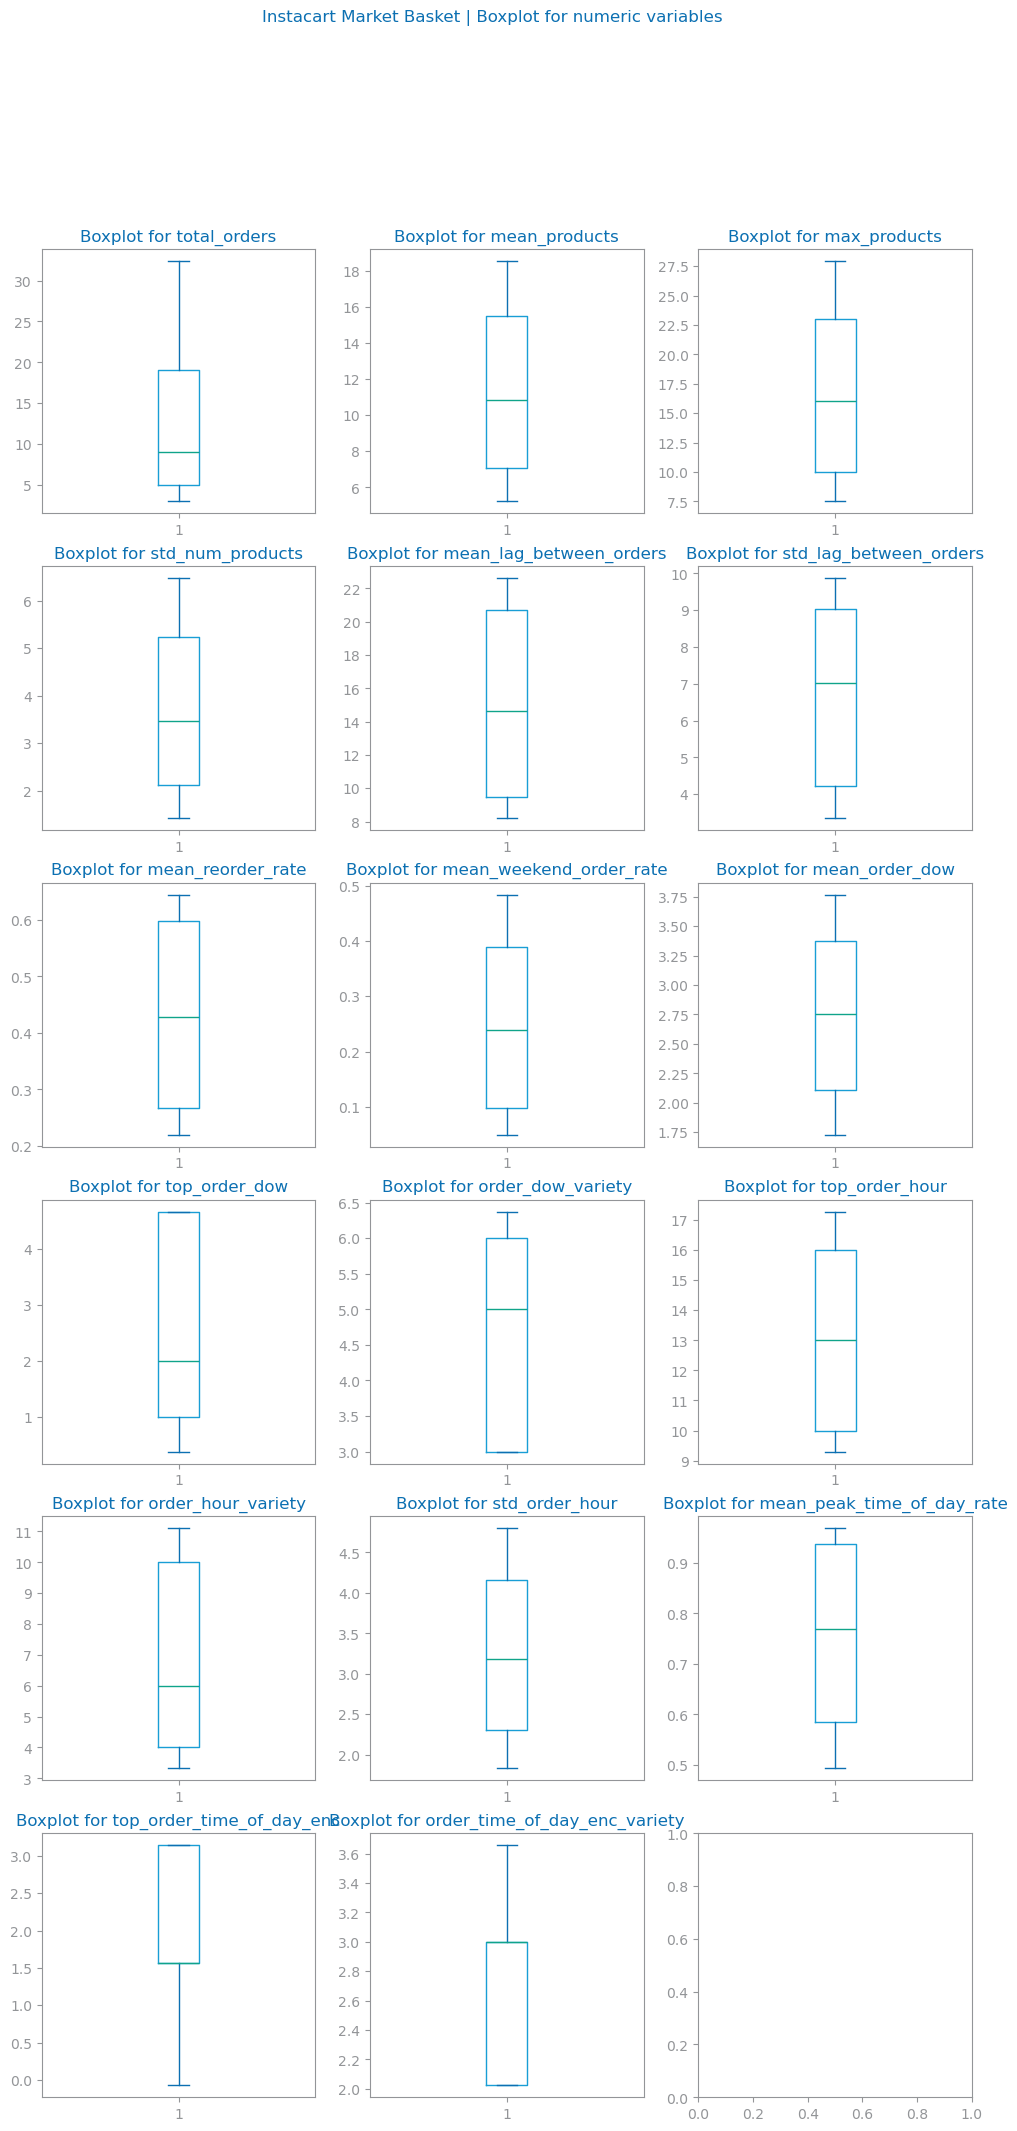

In [33]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## User Order feature selection and scaling

In [34]:

from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
reorder_numeric_features = users_df[numeric_vars]

# Replace infinite values with NaN
reorder_numeric_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
reorder_numeric_features.dropna(inplace=True)

# Normalize the data
scaler = StandardScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


# User Order KMEANS clustering

## User Order Elbow Method Studies

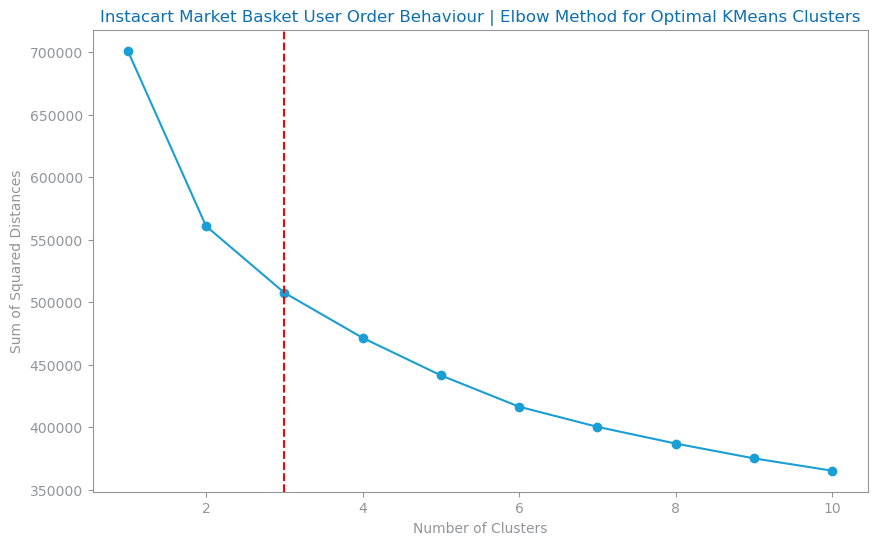

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reorder_numeric_features_scaled)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

## User Order Sillhouete study for kmeans

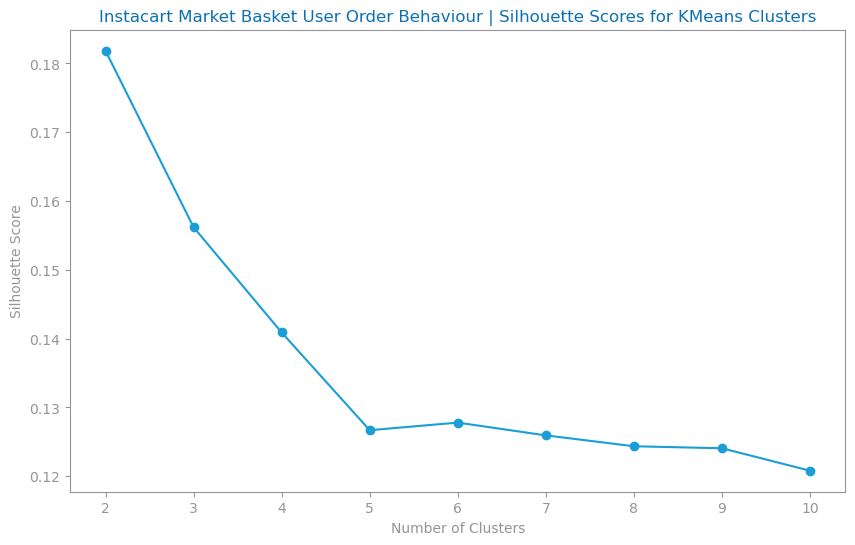

In [36]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reorder_numeric_features_scaled)
    silhouette_avg = silhouette_score(reorder_numeric_features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## User Order Kmeans model

In [ ]:
# Clustering
reorder_kmeans = KMeans(n_clusters=3, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)

reorder_kmeans.cluster_centers_

array([[-0.58529204, -0.48811194, -0.61578366, -0.56428984,  0.30815526,
         0.05202385, -0.45937229,  1.03554693,  1.11075743,  0.98428723,
        -0.44336964,  0.07957541, -0.54199297, -0.05452275, -0.11515454,
        -0.13567595, -0.27137768],
       [-0.63326325, -0.65747279, -0.79646318, -0.75971186,  0.38495879,
        -0.01447429, -0.46783416, -0.75697286, -0.73905775, -0.57739031,
        -0.65589128, -0.06497494, -0.70427908, -0.39899819,  0.18977188,
         0.00402579, -0.59253009],
       [ 1.20539333,  0.13266089,  0.38632246,  0.34899906, -0.76292475,
        -0.14971053,  0.8845366 ,  0.07782527,  0.04472224, -0.0420631 ,
         1.01263894, -0.02902155,  1.19356904,  0.50290539, -0.14284568,
         0.03156626,  0.82247131],
       [-0.46892858,  1.13221219,  1.04545445,  1.00370528,  0.38134824,
         0.197733  , -0.3092195 , -0.23263384, -0.28160671, -0.22060254,
        -0.28681917,  0.04527762, -0.40524438, -0.2209341 ,  0.10097795,
         0.08610094

# User Order Agglomerative

## User Order Sillouette Study for Agglomerative

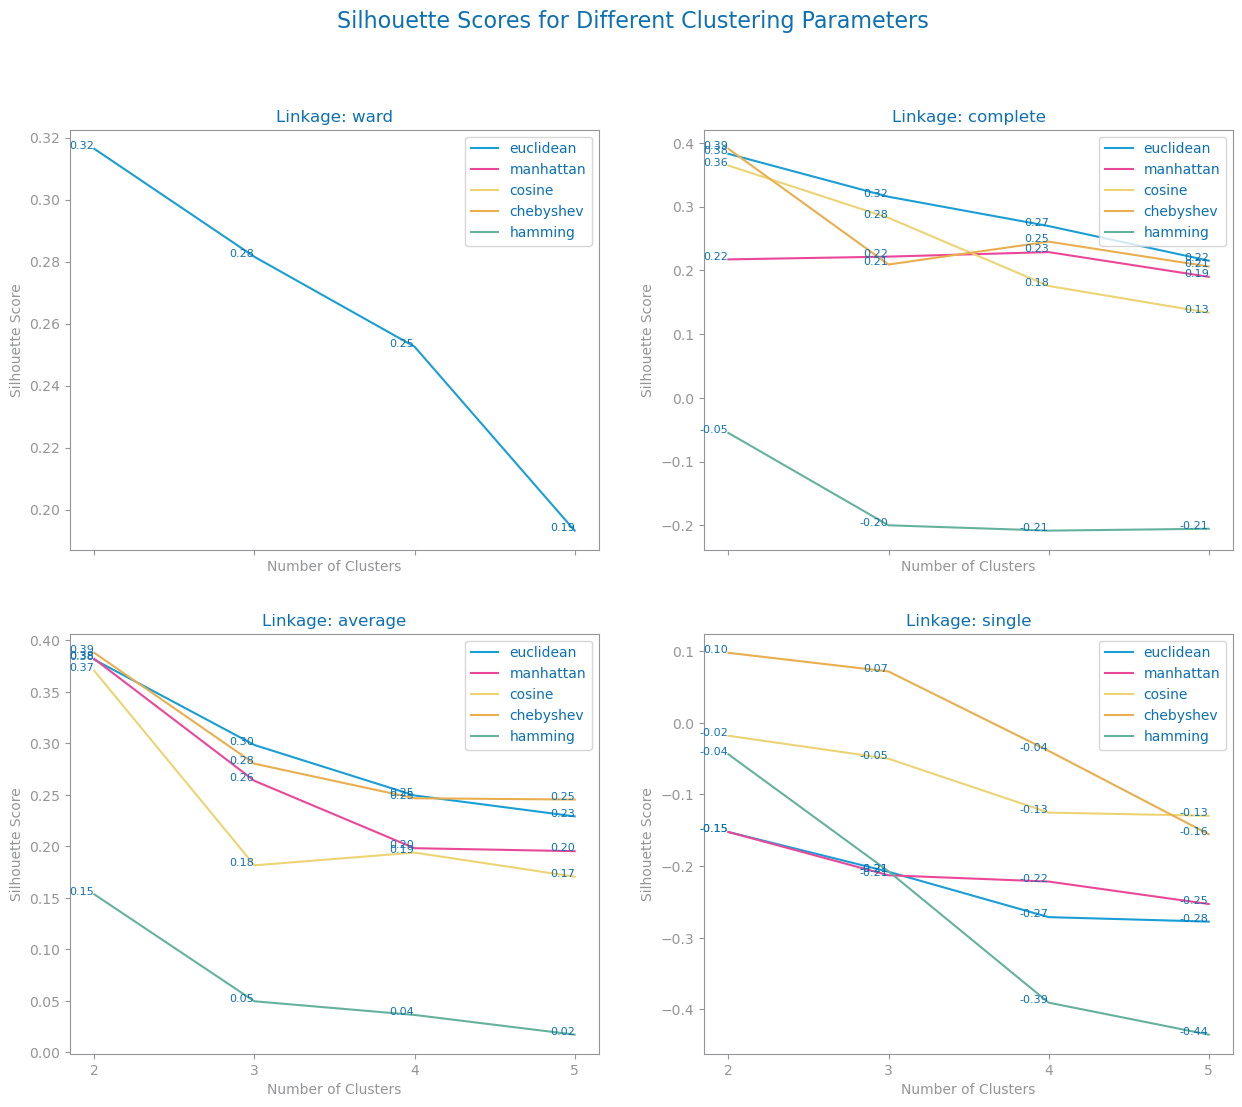

In [69]:
# Create a sample of the reorder_numeric features
reorder_numeric_features_sampled = reorder_numeric_features.sample(frac=0.1, random_state=42)

# Evaluate agglomerative clustering on the sampled data
evaluate_agglomerative_clustering(reorder_numeric_features_sampled, n_clusters_list=[2,3,4,5], scale='no')

## User Order Dendrogram

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reorder_numeric_features_sampled, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} User Order Behaviour | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


: 

: 

## User Order Agglomerative Model

In [ ]:
reorder_agglo = AgglomerativeClustering(n_clusters=3, metric='chebyshev', linkage='complete' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

reorder_y_pred_agglo

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

# Final User Order Model Evaluation

In [72]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.14090069728838572
Silhouette Score for Agglomerative Clustering: 0.14892262375145018


## User Order Cluster Labeling

In [73]:
# Add cluster labels to the dataframe
users_df['kmeans_cluster'] = reorder_y_pred_kmeans
users_df['agglo_cluster'] = reorder_y_pred_agglo

# Display the dataframe with the new cluster labels
users_df.head()

,user_id,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety,kmeans_cluster,agglo_cluster
0,30534,16.0,18.533009,27.917123,6.477393,18.940000,9.226316,0.511364,0.321970,2.234848,0.370510,6.0,9.298434,11.095975,4.797103,0.693182,1.570796,3.657301,2,0
1,161204,28.0,5.224347,7.506523,1.422275,9.941176,5.587170,0.644466,0.049285,2.264151,1.000000,5.0,10.000000,9.000000,2.838671,0.905660,1.570796,3.000000,2,0
2,140839,10.0,8.432432,13.000000,2.843310,12.871429,4.232111,0.621622,0.310811,3.189189,2.000000,6.0,9.298434,7.000000,3.972135,0.729730,1.570796,3.000000,2,1
3,153860,8.0,12.523810,18.000000,5.473859,22.596491,5.845816,0.428571,0.049285,2.269841,2.000000,4.0,15.000000,6.000000,3.179717,0.666667,3.141593,3.000000,3,0
4,7396,8.0,7.641509,12.000000,2.822263,22.621259,5.946911,0.528302,0.483350,3.716981,4.667946,5.0,15.000000,6.000000,2.537241,0.886792,3.141593,3.000000,0,1


### User Order Cluster Counts

In [63]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = users_df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = users_df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0     8781
1    10755
2    13217
3     8489
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    41241
1        1
dtype: int64


In [57]:
# agglo_weird_cluster = users_df[users_df['agglo_cluster']==1]

# agglo_weird_cluster

### User Order cluster boxplots

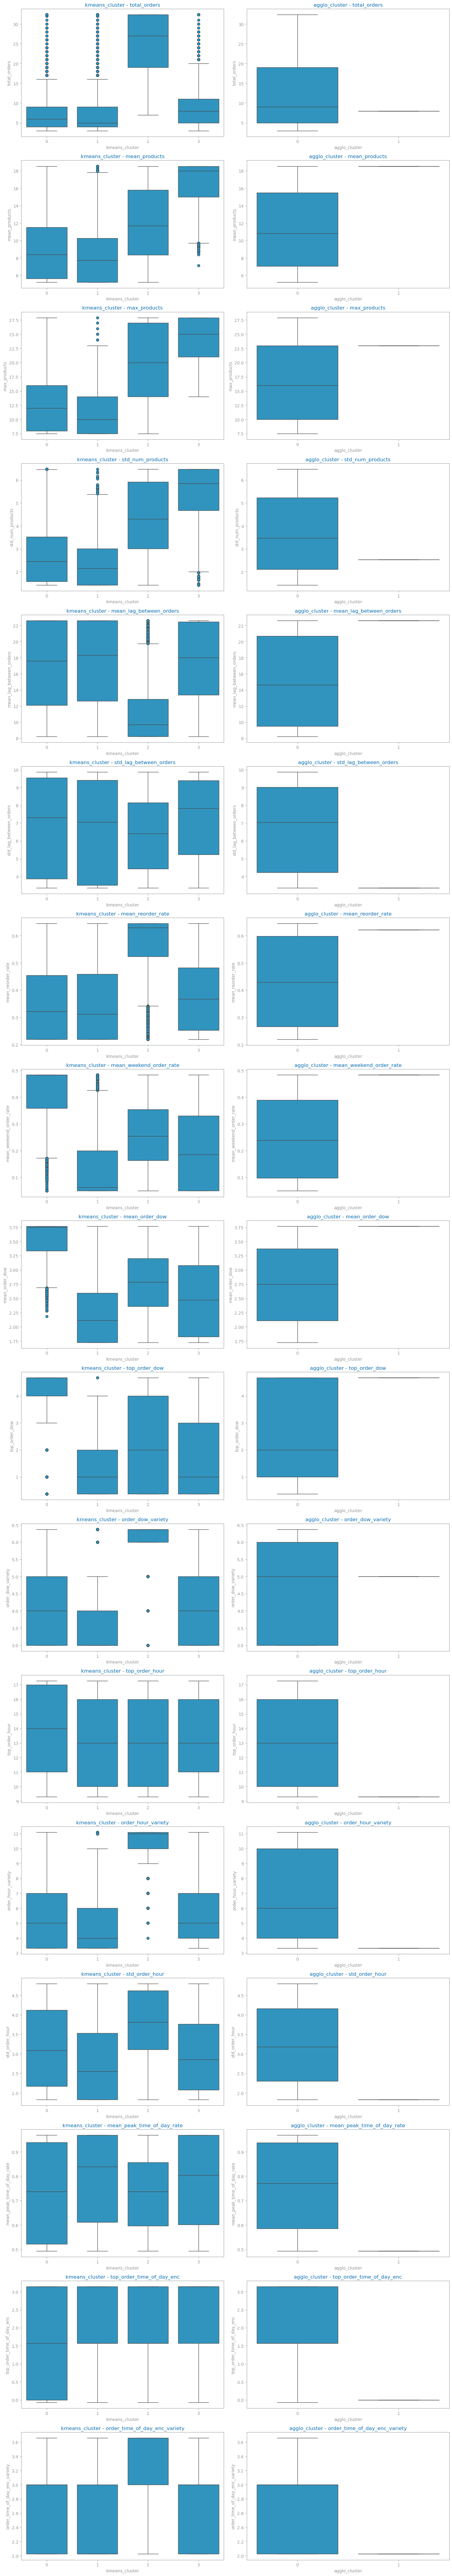

In [64]:

# Example usage
features = numeric_vars


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(users_df, features, cluster_labels)

## User Order PCA visualization

In [59]:
from sklearn.decomposition import PCA

# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.941297,1.616537,0.427096,1.110006,-1.841319,1.634631
1,0.658792,-0.551698,-3.271815,-1.571911,0.601503,0.359618
2,0.725430,-1.255981,-0.687143,-0.688489,0.607790,1.316051
3,-0.528279,1.453458,-0.104022,0.894767,-0.341231,-0.259078
4,-0.809469,-1.867124,1.255729,-1.372003,-0.561112,-0.843978


## User Order pca explained variance ratio

In [60]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_


print(f'Explained variance ratio: {explained_variance_reorder}')


Explained variance ratio: [0.2708579  0.15362945 0.13316818 0.12153715 0.07093099 0.05912261]


## User Order pca plot

### 2D PCA Plot

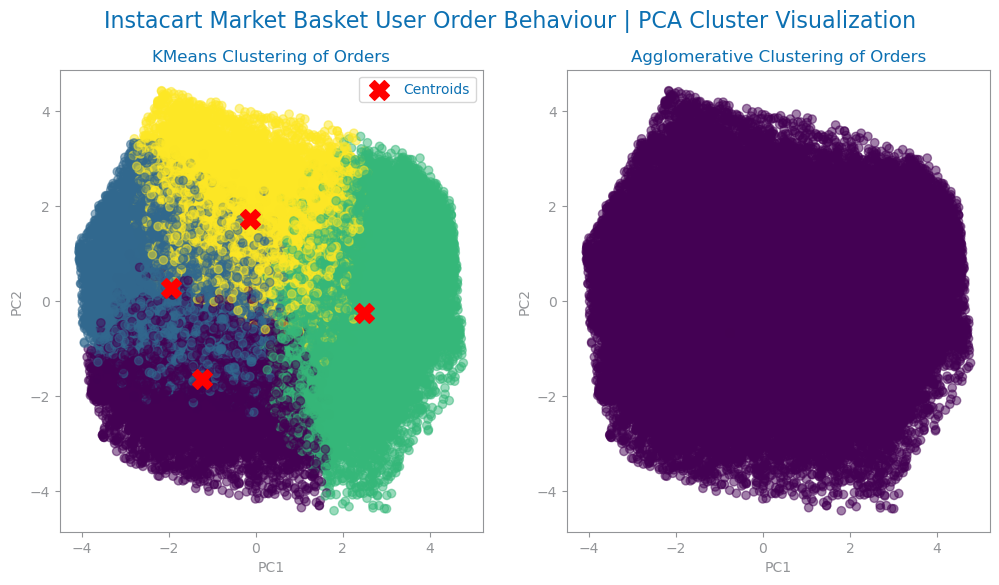

In [61]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(reorder_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')

plt.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

### PCA Plot 3D

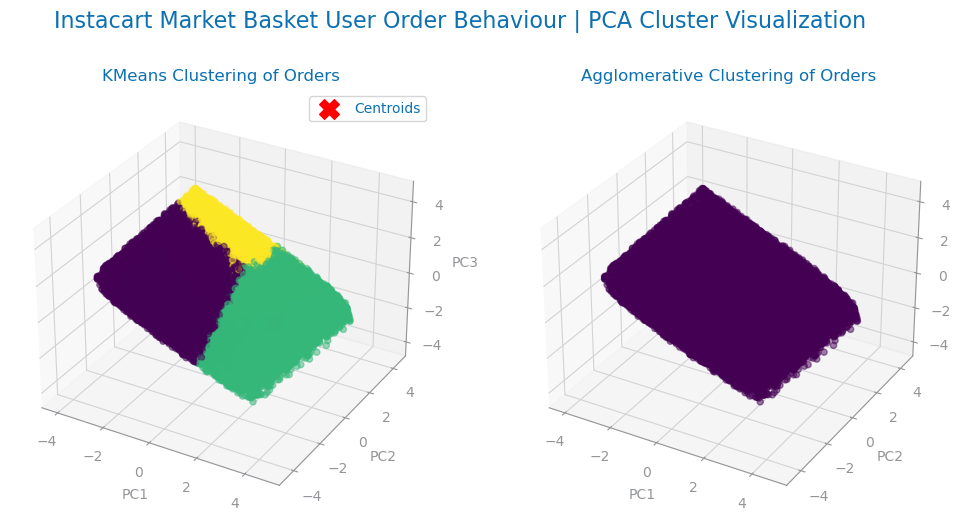

In [62]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(reorder_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering of Orders')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')

fig.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# outputs
